# **Overview: The code below is for the purpose of comparing the quality of the algorithms Lsa, KL, LexRank, TextRank, SumBasic, Luhn with the model I trained**

# **Connect to drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install Lib**

In [ ]:
!pip install transformers pyvi sentence-transformers underthesea torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 45.6 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=1af6a29f83641b9989ce5817e1d15ee80e0b1657a17

In [ ]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses sumy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 37.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=a3ab48a01159a6faf641c4e498b665481944f3c158176b7e8221b36f632078ae
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee97

# **Processing Data**

In [ ]:
def get_data(folder, offset, count):
  data = []
  for i in range(count):
    print(i)
    path = folder + "/{:06d}.txt.seg".format(i+offset+1)
    f = open(path, "r")
    lines = f.readlines()
    sum = ""
    content = ""
    empty = 0
    for line in lines:
      if(len(line) == 1):
        empty = empty +1
      elif(empty<1):
         sum += line + " . "
      elif(empty<2):
        sum +=line +" "
      elif(empty<3):
        content += line + " "
    sum = sum.replace("\n","")
    content = content.replace("\n","")
    result = {
        'summary':sum,
        'content':content
    }
    print("result", result)
    data.append(result)
  return data

def get_data_evalue(folder, offset, count):
  data = []
  for i in range(count):
    path = folder + "/summary_{:06d}.txt".format(i+offset+1)
    f = open(path, "r")
    lines = f.readlines()
    sum = ""
    for line in lines:
        sum += line.replace("_"," ") + " "
    sum = sum.replace("\n","")
    sum = sum.replace("<q>"," ")
    sum = sum.lower()
    data.append(sum)
  return data

def write_data(folder, offset, index, content):
  path = folder+"/summary_{:06d}.txt".format(offset+index+1)
  f = open(path, "w")
  f.write(content)
  f.close()

def get_stop_words_vn():
    path = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
    f = open(path, "r")
    lines = f.readlines()
    return lines

In [ ]:
import numpy as np
from numpy import ndarray
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from typing import List


class ClusterFeatures(object):

    def __init__(
        self,
        features: ndarray,
        algorithm: str = 'kmeans',
        pca_k: int = None,
        random_state: int = 12345
    ):

        if pca_k:
            self.features = PCA(n_components=pca_k).fit_transform(features)
        else:
            self.features = features

        self.algorithm = algorithm
        self.pca_k = pca_k
        self.random_state = random_state

    def __get_model(self, k: int):
        if self.algorithm == 'gmm':
            return GaussianMixture(n_components=k, random_state=self.random_state)
        return KMeans(n_clusters=k, random_state=self.random_state)

    def __get_centroids(self, model):
        if self.algorithm == 'gmm':
            return model.means_
        return model.cluster_centers_

    def __find_closest_args(self, centroids: np.ndarray):
        centroid_min = 1e10
        cur_arg = -1
        args = {}
        used_idx = []

        for j, centroid in enumerate(centroids):

            for i, feature in enumerate(self.features):
                value = np.linalg.norm(feature - centroid)

                if value < centroid_min and i not in used_idx:
                    cur_arg = i
                    centroid_min = value

            used_idx.append(cur_arg)
            args[j] = cur_arg
            centroid_min = 1e10
            cur_arg = -1

        return args

    def cluster(self, ratio: float = 0.1) -> List[int]:
        k = 1 if ratio * len(self.features) < 1 else int(len(self.features) * ratio)
        model = self.__get_model(k).fit(self.features)
        centroids = self.__get_centroids(model)
        cluster_args = self.__find_closest_args(centroids)
        sorted_values = sorted(cluster_args.values())
        return sorted_values

    def __call__(self, ratio: float = 0.1) -> List[int]:
        return self.cluster(ratio)

In [ ]:
stop_words = get_stop_words_vn()

In [ ]:
from typing import List
from abc import abstractmethod
from spacy.lang.vi import Vietnamese
import numpy as np
import nltk
from nltk import sent_tokenize

class ModelProcessor(object):

    def __init__(self, random_state: int = 12345 ):
        np.random.seed(random_state)
        self.random_state = random_state

    def process_content_sentences(self, body: str, min_length=5, max_length=50) -> List[str]:
        for word in stop_words:
          body.replace(word, "")
        sents = [s.strip() for s in sent_tokenize(body)]
        return [c for c in sents if max_length > len(c.split(" ")) > min_length]

    @abstractmethod
    def run_clusters(self,model, content: List[str], ratio=0.2, algorithm='kmeans', use_first: bool=False) -> List[str]:
        raise NotImplementedError("Must Implement run_clusters")

    def run(
        self,
        model,
        body: str,
        ratio: float=0.2,
        min_length: int=4,
        max_length: int=50,
        use_first: bool=False,
        algorithm='kmeans'
    ) -> str:
        sentences = self.process_content_sentences(body, min_length, max_length)
        if sentences:
            sentences = self.run_clusters(model, sentences, ratio, algorithm, use_first)

        return ' '.join(sentences)

    def __call__(self, model, body: str, ratio: float=0.2, min_length: int=4, max_length: int=50,
                 use_first: bool=False, algorithm='kmeans') -> str:
        return self.run(model, body, ratio, min_length, max_length)


class SingleModel(ModelProcessor):


    def __init__(
        self,
        random_state: int=12345
    ):
        super(SingleModel, self).__init__(random_state=random_state)

    """
    Deprecated for naming sake.
    """
    def run_clusters(self,model, content: List[str], ratio=0.2, algorithm='kmeans', use_first: bool= False) -> List[str]:
        # hidden = model.encode(content)
        hidden = embedding_sentences(content)
        hidden_args = ClusterFeatures(hidden, algorithm, random_state=self.random_state).cluster(ratio)

        if use_first:
            if hidden_args[0] != 0:
                hidden_args.insert(0,0)

        return [content[j] for j in hidden_args]


class Summarizer(SingleModel):
    def __init__(self,   random_state: int=12345):
        super(Summarizer, self).__init__(random_state)

# **Inference data**

In [ ]:
path_result = "/content/drive/MyDrive/LLM_TEXT/inference/infer_1/"
path_data_test = "/content/drive/MyDrive/LLM_TEXT/dataset/test_tokenized"
size_data_test = 10 #default 500
listAlorithms = ['KLSummarizer','LexRankSummarizer','LsaSummarizer','LuhnSummarizer','SumBasicSummarizer','TextRankSummarizer']
models = listAlorithms
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
data = get_data(path_data_test, 0, size_data_test)
RATIO = 0.2
stop_words = get_stop_words_vn()

0
result {'summary': 'Bản_án cho đối_tượng giả_danh công_an để lừa_đảo . Ngày 25/2 , TAND TP. Đà_Nẵng tuyên_phạt Hồ_Xuân_Huy ( SN 1994 ) , ngụ quận Hải_Châu , 12 năm tù về tội Lừa_đảo chiếm_đoạt tài_sản . ', 'content': 'Theo lời khai của Huy tại phiên_toà , để có tiền sử_dụng cá_nhân , Huy “ nổ ” là sĩ_quan cục Phòng_chống ma_tuý của bộ Công_an đóng tại TP. Đà_Nẵng , có nguồn mua ô_tô thanh_lý giá rẻ , và khả_năng chạy việc vào ngành công_an . Chỉ với lời “ nổ ” này , từ tháng 10/2016 đến 9/2017 , nhiều người đã bị lừa_đảo với tổng_số tiền 3,2 tỷ đồng . Trong đó , người bị Huy lừa nhiều nhất là vợ_chồng ông Bảo_Th . , ngụ quận Hải_Châu . Huy giới_thiệu với cặp vợ_chồng này mình có suất mua ô_tô thanh_lý giá rẻ và rủ họ mua cùng . Tin lời , vợ_chồng ông Th . đưa cho Huy hơn 1 tỷ đồng . Cùng thủ_đoạn , Huy lừa thêm ông Nguyễn_Tấn_T. 970 triệu đồng , Lê_Quốc_Th . 400 triệu đồng , Trần_Nhật_S. 300 triệu đồng … Sau chiêu_thức mua xe thanh_lý , Huy chuyển sang giả_vờ có khả_năng xin việc vào

In [ ]:
class TokenizerVNVal:
    @staticmethod
    def to_sentences(text: str):
        return [s.strip() for s in text.split(".")]
    @staticmethod
    def to_words(sentence: str):
        # sentence = sentence.replace("_", " ")
        return [w.strip() for w in sentence.split(" ")]

## **Inference data with my model** (OnGoiing)




In [ ]:
!pip install dill==0.3.5.1
!pip install rouge_score datasets==1.0.2
myModelName = 'Model "custom PhoBERT"'
import os
new_path = "/content/drive/MyDrive/LLM_TEXT/"
os.chdir(new_path)
current_path = os.getcwd()
print("current path:", current_path)

current path: /content/drive/MyDrive/LLM_TEXT


In [ ]:
!pip install transformers

In [ ]:
import glob
import pandas as pd
import concurrent.futures
from datasets import *
import datasets
import transformers

from seq2seq_trainer import Seq2SeqTrainer
from transformers import TrainingArguments
from dataclasses import dataclass, field
from typing import Optional

In [ ]:
def listPaths(path):
  pathfiles = list()
  cnt = 0
  for pathfile in glob.glob(path):
    cnt += 1
    pathfiles.append(pathfile)
    if cnt == size_data_test:
       break
  return pathfiles

test_paths = listPaths('/content/drive/MyDrive/LLM_TEXT/dataset/test_tokenized/*')

In [ ]:
def read_content(pathfile):
  """
  Input: Path of txt file
  Output: A dictionary has keys 'original' and 'summary'
  """
  with open(pathfile) as f:
    rows  = f.readlines()
    original = ' '.join(''.join(rows[4:]).split('\n'))
    summary = ' '.join(rows[2].split('\n'))

  return {'file' : pathfile,
          'original': original,
          'summary': summary}

def get_dataframe(pathfiles):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    data = executor.map(read_content, pathfiles)

  # Make blank dataframe
  data_df = list()
  for d in data:
    data_df.append(d)
  data_df = pd.DataFrame(data_df)
  data_df.dropna(inplace = True)
  data_df = data_df.sample(frac=1).reset_index(drop=True)

  return data_df

In [ ]:
test_df = get_dataframe(test_paths)
test_data =  Dataset.from_pandas(test_df)

In [ ]:
import datasets
from transformers import RobertaTokenizer, EncoderDecoderModel, AutoTokenizer
from sklearn.model_selection import train_test_split


tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/LLM_TEXT/training/checkpoint-180000')
model.to("cpu")

# test_data = datasets.load_dataset("xsum", split="test")

batch_size = 32  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    inputs = tokenizer(batch["original"], padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cpu")
    attention_mask = inputs.attention_mask.to("cpu")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["original"])

pred_str = results["pred"]
label_str = results["summary"]

print ("test_data: ",test_data[0]["summary"] )
print ("pred: ",pred_str[0] )
print ("summary: ",label_str[0] )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

test_data:  Đêm 27/11 , áp_thấp_nhiệt_đới đã đi vào đông nam biển Đông và sáng nay mạnh lên thành bão với tên quốc_tế là Sinlaku . Dự_báo tối 29/11 , bão sẽ đổ_bộ Nam_Trung_Bộ . 
pred:  Sáng hải_trình dự_kiến cách bờ biển các tỉnh từ Bình_Định đến Khánh_Hoà khoảng 300 km, bão Sinlaku đã mạnh lên thành bão và có tên quốc_tế là
summary:  Đêm 27/11 , áp_thấp_nhiệt_đới đã đi vào đông nam biển Đông và sáng nay mạnh lên thành bão với tên quốc_tế là Sinlaku . Dự_báo tối 29/11 , bão sẽ đổ_bộ Nam_Trung_Bộ . 


In [ ]:
rouge = datasets.load_metric("rouge")
rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge1","rouge2","rougeL"])

In [ ]:
for key,value in rouge_output.items():
  print(key)
  print(value.mid)
  print(value.mid[0])

rouge1
Score(precision=0.6279640201068772, recall=0.5652676097575228, fmeasure=0.593008042948536)
0.6279640201068772
rouge2
Score(precision=0.2867040581157868, recall=0.2567501022190012, fmeasure=0.27029461677423305)
0.2867040581157868
rougeL
Score(precision=0.38672192886478596, recall=0.347417340889694, fmeasure=0.36483787918793087)
0.38672192886478596


In [ ]:
def getRougeMyModel():
   print("model: ", myModelName)
   for key,value in rouge_output.items():
      if key == "rouge1":
         rouge1_recall.append(value.mid[0])
         rouge1_precision.append(value.mid[1])
         rouge1_f1.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall.append(value.mid[0])
         rouge2_precision.append(value.mid[1])
         rouge2_f1.append(value.mid[2])
         models.append(myModelName)
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[1])






## **Inference data with algorithms** [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]





In [ ]:
import os
import re

def folderExist(folder_path):
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

def clean_text(text):
  text = text.replace("\n"," ")
  text = re.sub("\s\s+"," ",text)
  text = text.replace("TP.", "TP")
  text = re.sub("\.\.+",".",text)
  text = re.sub("…",".",text)
  all_number = re.findall("\d*\.\d+",text)
  all_dot = re.findall("[A-Z|Ê|Ư|Ơ|Â|Ă|Đ]\s*\.", text)
  text_dot = re.findall("\.\s+[^A-Z|Ê|Ư|Ơ|Â|Ă|Đ]", text)
  for w in all_number:
    text = text.replace(w, w.replace(".",""))
  for w in all_dot:
    text = text.replace(w, w.replace(".",""))
  for w in text_dot:
    text = text.replace(w, w.replace(".",""))
  text = re.sub(r"[()\"#@:<>{}`+=~|!“”]", "", text)
  print("allnumber:",all_number)
  print("all_dot",all_dot)
  print('text_dot:',text_dot)
  return text

In [ ]:
def load_sum(model, content, index):
  name_model = str(type(model)).split(".")[-1].replace("'>","")
  result = ''
  path = path_result + name_model
  folderExist(path)
  lenght = len(parser.document.sentences)
  count = 1 if RATIO * lenght < 1 else lenght * RATIO
  for sentence in model(content, count):
      result += str(sentence) +" "
  write_data(path, 0, idx, result)

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.utils import get_stop_words
import nltk

SENTENCES_COUNT = 3

if __name__ == "__main__":
    # or for plain text files
    # parser = PlaintextParser.from_file("document.txt", Tokenizer(LANGUAGE))
    # parser = PlaintextParser.from_string("Check this out.", Tokenizer(LANGUAGE))
    lsaSummarizer = LsaSummarizer()
    lsaSummarizer.stop_words = get_stop_words_vn()
    kLSummarizer = KLSummarizer()
    kLSummarizer.stop_words = get_stop_words_vn()
    lexRankSummarizer = LexRankSummarizer()
    lexRankSummarizer.stop_words = get_stop_words_vn()
    luhnSummarizer = LuhnSummarizer()
    luhnSummarizer.stop_words = get_stop_words_vn()
    textRankSummarizer = TextRankSummarizer()
    textRankSummarizer.stop_words = get_stop_words_vn()
    sumBasicSummarizer = SumBasicSummarizer()
    sumBasicSummarizer.stop_words = get_stop_words_vn()
    for idx, story in enumerate(data):
        print(idx)
        parser = PlaintextParser.from_string(clean_text(story['content']), TokenizerVNVal)
        load_sum(lsaSummarizer, parser.document, idx)
        load_sum(kLSummarizer, parser.document, idx)
        load_sum(lexRankSummarizer, parser.document, idx)
        load_sum(textRankSummarizer, parser.document, idx)
        load_sum(luhnSummarizer, parser.document, idx)
        load_sum(sumBasicSummarizer, parser.document, idx)


    # for sentence in summarizer(parser.document, SENTENCES_COUNT):
    #     print(sentence)

0
allnumber: []
all_dot ['T.', 'S.', 'H.', 'H.', 'H.']
text_dot: ['. ,', '. đ', '. 9', '. 4', '. 3', '. 2', '. đ', '. đ']
1
allnumber: []
all_dot []
text_dot: ['. "', '. t']
2
allnumber: ['32.100', '2.900', '.000', '3.300', '.000']
all_dot ['M.', 'S .', 'S.']
text_dot: ['. c', '. “', '. ”', '. "']
3
allnumber: []
all_dot []
text_dot: ['. v', '. t', '. Ô', '. "', '. d', '. ,', '. c']
4
allnumber: []
all_dot []
text_dot: ['. “']
5
allnumber: ['700.000']
all_dot ['V.', 'V .', 'V.', 'V.']
text_dot: ['. ,', '. k', '. m']
6
allnumber: []
all_dot []
text_dot: ['. “', '. Ô']
7
allnumber: []
all_dot ['S .']
text_dot: ['. 8']
8
allnumber: []
all_dot []
text_dot: ['. “']
9
allnumber: []
all_dot []
text_dot: []


In [ ]:
from sumy.models.dom import Sentence
E = 0.00001
def _get_ngrams(n, text):
    ngram_set = set()
    text_length = len(text)
    max_index_ngram_start = text_length - n
    for i in range(max_index_ngram_start + 1):
        ngram_set.add(tuple(text[i:i + n]))
    return ngram_set


def _split_into_words(sentences):
    full_text_words = []
    for s in sentences:
        if not isinstance(s, Sentence):
            raise (ValueError("Object in collection must be of type Sentence"))
        full_text_words.extend(s.words)
    return full_text_words


def _get_word_ngrams(n, sentences):
    assert (len(sentences) > 0)
    assert (n > 0)

    words = set()
    for sentence in sentences:
        words.update(_get_ngrams(n, _split_into_words([sentence])))

    return words


def _get_index_of_lcs(x, y):
    return len(x), len(y)


def _len_lcs(x, y):
    table = _lcs(x, y)
    n, m = _get_index_of_lcs(x, y)
    return table[n, m]


def _lcs(x, y):

    n, m = _get_index_of_lcs(x, y)
    table = dict()
    for i in range(n + 1):
        for j in range(m + 1):
            if i == 0 or j == 0:
                table[i, j] = 0
            elif x[i - 1] == y[j - 1]:
                table[i, j] = table[i - 1, j - 1] + 1
            else:
                table[i, j] = max(table[i - 1, j], table[i, j - 1])
    return table


def _recon_lcs(x, y):

    table = _lcs(x, y)

    def _recon(i, j):
        if i == 0 or j == 0:
            return []
        elif x[i - 1] == y[j - 1]:
            return _recon(i - 1, j - 1) + [(x[i - 1], i)]
        elif table[i - 1, j] > table[i, j - 1]:
            return _recon(i - 1, j)
        else:
            return _recon(i, j - 1)

    i, j = _get_index_of_lcs(x, y)
    recon_tuple = tuple(map(lambda r: r[0], _recon(i, j)))
    return recon_tuple


def rouge_n(evaluated_sentences, reference_sentences, n=2):

    if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
        raise (ValueError("Collections must contain at least 1 sentence."))

    evaluated_ngrams = _get_word_ngrams(n, evaluated_sentences)
    reference_ngrams = _get_word_ngrams(n, reference_sentences)
    reference_count = len(reference_ngrams)
    evaluated_count = len(evaluated_ngrams)

    # Gets the overlapping ngrams between evaluated and reference
    overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
    overlapping_count = len(overlapping_ngrams)
    recall = overlapping_count / reference_count
    precision = overlapping_count / (evaluated_count + E)
    f_mesure = (2*recall*precision)/(recall+precision + E)
    return  recall, precision, f_mesure


def rouge_1(evaluated_sentences, reference_sentences):

    return rouge_n(evaluated_sentences, reference_sentences, 1)


def rouge_2(evaluated_sentences, reference_sentences):

    return rouge_n(evaluated_sentences, reference_sentences, 2)


def _f_lcs(llcs, m, n):

    r_lcs = llcs / m
    p_lcs = llcs / n
    beta = p_lcs / (r_lcs+E)
    num = (1 + (beta ** 2)) * r_lcs * p_lcs
    denom = r_lcs + ((beta ** 2) * p_lcs)
    return num / (denom+E)


def rouge_l_sentence_level(evaluated_sentences, reference_sentences):

    if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
        raise (ValueError("Collections must contain at least 1 sentence."))
    reference_words = _split_into_words(reference_sentences)
    evaluated_words = _split_into_words(evaluated_sentences)
    m = len(reference_words)
    n = len(evaluated_words)
    lcs = _len_lcs(evaluated_words, reference_words)
    return _f_lcs(lcs, m, n)


def _union_lcs(evaluated_sentences, reference_sentence):

    if len(evaluated_sentences) <= 0:
        raise (ValueError("Collections must contain at least 1 sentence."))

    lcs_union = set()
    reference_words = _split_into_words([reference_sentence])
    combined_lcs_length = 0
    for eval_s in evaluated_sentences:
        evaluated_words = _split_into_words([eval_s])
        lcs = set(_recon_lcs(reference_words, evaluated_words))
        combined_lcs_length += len(lcs)
        lcs_union = lcs_union.union(lcs)

    union_lcs_count = len(lcs_union)
    union_lcs_value = union_lcs_count / (combined_lcs_length+E)
    return union_lcs_value


def rouge_l_summary_level(evaluated_sentences, reference_sentences):

    if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
        raise (ValueError("Collections must contain at least 1 sentence."))

    # total number of words in reference sentences
    m = len(_split_into_words(reference_sentences))

    # total number of words in evaluated sentences
    n = len(_split_into_words(evaluated_sentences))

    union_lcs_sum_across_all_references = 0
    for ref_s in reference_sentences:
        union_lcs_sum_across_all_references += _union_lcs(evaluated_sentences, ref_s)
    return _f_lcs(union_lcs_sum_across_all_references, m, n)

In [ ]:
path_ref = "/content/drive/MyDrive/LLM_TEXT/inference/summary_original"
data_ref = get_data_evalue(path_ref, 0, size_data_test)

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from statistics import mean, median

def evalue(model):
    path_sum = path_result +"/" +  model
    data_sum = get_data_evalue(path_sum, 0, size_data_test)
    r1_recall = []
    r1_precision = []
    r1_f = []

    r2_recall= []
    r2_precision = []
    r2_f = []
    rl_sent = []
    rl_sum = []
    for idx in range(len(data_ref)):
        # if idx %2 == 0:
        #   print(idx)
        ref_parse = PlaintextParser.from_string(data_ref[idx], TokenizerVNVal)
        sum_parse = PlaintextParser.from_string(data_sum[idx], TokenizerVNVal)
        if len(sum_parse.document.sentences) <= 0 or len(ref_parse.document.sentences) <=0:
          continue
        e_r1_recall, e_r1_precision, e_r1_f1 = rouge_1(sum_parse.document.sentences, ref_parse.document.sentences)
        e_r2_recall, e_r2_precision, e_r2_f1 = rouge_2(sum_parse.document.sentences, ref_parse.document.sentences)
        e_rl_sent = rouge_l_sentence_level(sum_parse.document.sentences, ref_parse.document.sentences)
        e_rl_sum = rouge_l_summary_level(sum_parse.document.sentences, ref_parse.document.sentences)
        r1_recall.append(e_r1_recall)
        r1_precision.append(e_r1_precision)
        r1_f.append(e_r1_f1)
        r2_recall.append(e_r2_recall)
        r2_precision.append(e_r2_precision)
        r2_f.append(e_r2_f1)
        rl_sent.append(e_rl_sent)
        # rl_sum.append(e_rl_sum)
    print('model: ',model)
    mer1_recall =  mean(r1_recall)
    merr1_precision = mean(r1_precision)
    f1_Score1 = 2/(1/mean(r1_recall) + 1/mean(r1_precision))

    mer2_recall =  mean(r2_recall)
    merr2_precision = mean(r2_precision)
    f1_Score2 = 2/(1/mean(r2_recall) + 1/mean(r2_precision))
    print('rouge1:recall', mer1_recall,"-precision",merr1_precision,'-F1-Score',f1_Score1)
    print('rouge2:recall', mer2_recall,"-precision",merr2_precision,'-F1-Score',f1_Score2)
    # print('rouge2:recall',mean(r2_recall),"-precision",mean(r2_precision),'-F1-Score',mean(r2_f))
    # print('\n rougeL_sent:',mean(rl_sent))
    # print('\n rougeL_sum:',mean(rl_sum))
    rouge1_recall.append(mer1_recall)
    rouge1_precision.append(merr1_precision)
    rouge1_f1.append(f1_Score1)

    rouge2_recall.append(mer2_recall)
    rouge2_precision.append(merr2_precision)
    rouge2_f1.append(f1_Score2)


In [ ]:
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
models = listAlorithms
for model in models:
  if model != myModelName:
    evalue(model)

getRougeMyModel()


model:  KLSummarizer
rouge1:recall 0.3010933037134557 -precision 0.1932265097897237 -F1-Score 0.23539096191714393
rouge2:recall 0.10764062397620178 -precision 0.06179133136007626 -F1-Score 0.07851243232975563
model:  LexRankSummarizer
rouge1:recall 0.43287202929949564 -precision 0.20113232721038463 -F1-Score 0.2746497172876526
rouge2:recall 0.18136435367113285 -precision 0.06685228873187143 -F1-Score 0.09769386951585862
model:  LsaSummarizer
rouge1:recall 0.3571754869182117 -precision 0.26691411224521355 -F1-Score 0.30551759918550325
rouge2:recall 0.14146356434378715 -precision 0.11035325923163725 -F1-Score 0.12398667544295769
model:  LuhnSummarizer
rouge1:recall 0.46989448166778924 -precision 0.2020657916875759 -F1-Score 0.2826048033277438
rouge2:recall 0.19319068666379596 -precision 0.07305469820960177 -F1-Score 0.10601864379989498
model:  SumBasicSummarizer
rouge1:recall 0.3344134283754133 -precision 0.2522752898352382 -F1-Score 0.2875945691456503
rouge2:recall 0.12960523517624287 -

# **Draw a comparison chart**

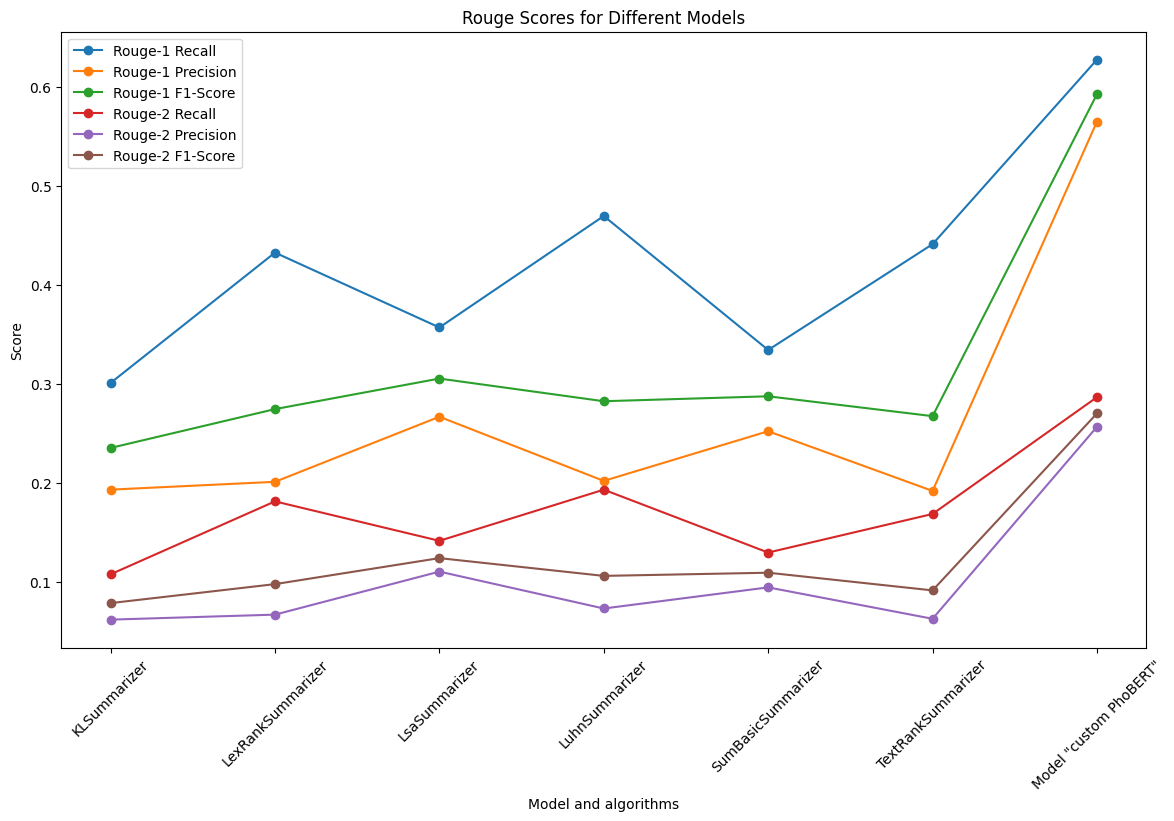

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))
plt.plot(models, rouge1_recall, marker='o', linestyle='-', label='Rouge-1 Recall')
plt.plot(models, rouge1_precision, marker='o', linestyle='-', label='Rouge-1 Precision')
plt.plot(models, rouge1_f1, marker='o', linestyle='-', label='Rouge-1 F1-Score')

plt.plot(models, rouge2_recall, marker='o', linestyle='-', label='Rouge-2 Recall')
plt.plot(models, rouge2_precision, marker='o', linestyle='-', label='Rouge-2 Precision')
plt.plot(models, rouge2_f1, marker='o', linestyle='-', label='Rouge-2 F1-Score')
plt.xlabel('Model and algorithms')
plt.ylabel('Score')
plt.title('Rouge Scores for Different Models')
plt.legend()
plt.xticks(rotation=45)
plt.show()

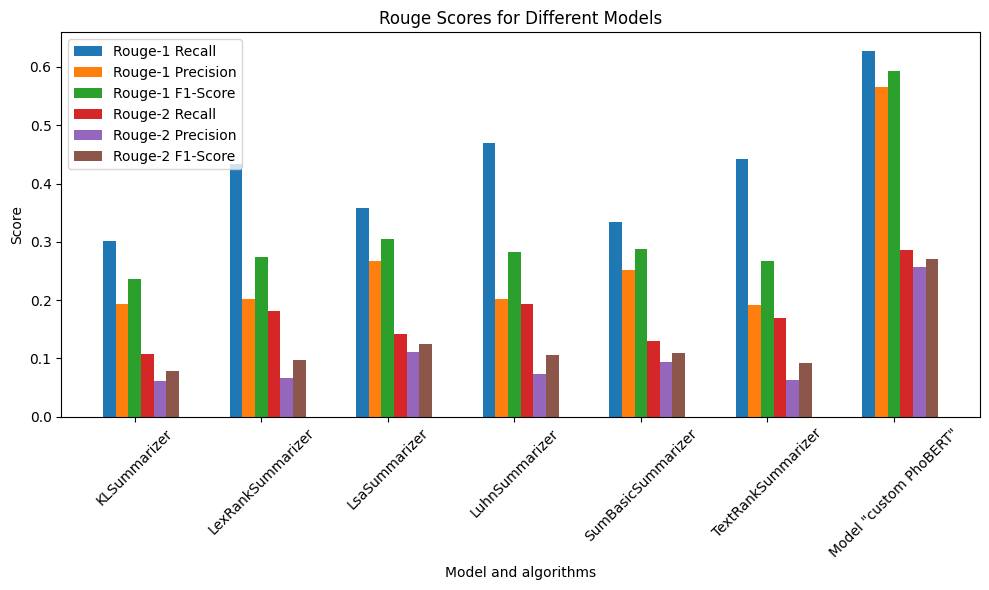

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(len(models))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1, width, label='Rouge-2 F1-Score')
plt.xlabel('Model and algorithms')
plt.ylabel('Score')
plt.title('Rouge Scores for Different Models')
plt.xticks(x + 2 * width, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()